# LangGraph and LangSmith - Agentic RAG Powered by LangChain

In the following notebook we'll complete the following tasks:

- 🤝 Breakout Room #1:
  1. Install required libraries
  2. Set Environment Variables
  3. Creating our Tool Belt
  4. Creating Our State
  5. Creating and Compiling A Graph!

- 🤝 Breakout Room #2:
  1. Evaluating the LangGraph Application with LangSmith
  2. Adding Helpfulness Check and "Loop" Limits
  3. LangGraph for the "Patterns" of GenAI

# 🤝 Breakout Room #1

## Part 1: LangGraph - Building Cyclic Applications with LangChain

LangGraph is a tool that leverages LangChain Expression Language to build coordinated multi-actor and stateful applications that includes cyclic behaviour.

### Why Cycles?

In essence, we can think of a cycle in our graph as a more robust and customizable loop. It allows us to keep our application agent-forward while still giving the powerful functionality of traditional loops.

Due to the inclusion of cycles over loops, we can also compose rather complex flows through our graph in a much more readable and natural fashion. Effectively allowing us to recreate application flowcharts in code in an almost 1-to-1 fashion.

### Why LangGraph?

Beyond the agent-forward approach - we can easily compose and combine traditional "DAG" (directed acyclic graph) chains with powerful cyclic behaviour due to the tight integration with LCEL. This means it's a natural extension to LangChain's core offerings!

## Task 1:  Dependencies


## Task 2: Environment Variables

We'll want to set both our OpenAI API key and our LangSmith environment variables.

In [1]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

In [2]:
os.environ["TAVILY_API_KEY"] = getpass.getpass("TAVILY_API_KEY")

In [3]:
from uuid import uuid4

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE7 - LangGraph - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key: ")

## Task 3: Creating our Tool Belt

As is usually the case, we'll want to equip our agent with a toolbelt to help answer questions and add external knowledge.

There's a tonne of tools in the [LangChain Community Repo](https://github.com/langchain-ai/langchain-community/tree/main/libs/community) but we'll stick to a couple just so we can observe the cyclic nature of LangGraph in action!

We'll leverage:

- [Tavily Search Results](https://github.com/langchain-ai/langchain-community/blob/main/libs/community/langchain_community/tools/tavily_search/tool.py)
- [Arxiv](https://github.com/langchain-ai/langchain-community/blob/main/libs/community/langchain_community/tools/arxiv/tool.py)

#### 🏗️ Activity #1:

Please add the tools to use into our toolbelt.

> NOTE: Each tool in our toolbelt should be a method.

In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools.arxiv.tool import ArxivQueryRun

tavily_tool = TavilySearchResults(max_results=5)

tool_belt = [
    tavily_tool,
    ArxivQueryRun(),
]

/var/folders/c2/glf9lbds67z8s694b_6yzxp00000gn/T/ipykernel_44429/1203815797.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_tool = TavilySearchResults(max_results=5)


### Model

Now we can set-up our model! We'll leverage the familiar OpenAI model suite for this example - but it's not *necessary* to use with LangGraph. LangGraph supports all models - though you might not find success with smaller models - as such, they recommend you stick with:

- OpenAI's GPT-3.5 and GPT-4
- Anthropic's Claude
- Google's Gemini

> NOTE: Because we're leveraging the OpenAI function calling API - we'll need to use OpenAI *for this specific example* (or any other service that exposes an OpenAI-style function calling API.

In [5]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4.1-nano", temperature=0)

Now that we have our model set-up, let's "put on the tool belt", which is to say: We'll bind our LangChain formatted tools to the model in an OpenAI function calling format.

In [6]:
model = model.bind_tools(tool_belt)

#### ❓ Question #1:

How does the model determine which tool to use?

- [bind_tools](https://python.langchain.com/docs/integrations/chat/openai/#chatopenaibind_tools) gives our LLM (within its prompt context for each user request) the name, description, and parameters (JSON schema) for each of our functions in `tool_belt`. Then when the LLM is fulfilling a user request, it can recognize which tools may be relevant to the current task.

## Task 4: Putting the State in Stateful

Earlier we used this phrasing:

`coordinated multi-actor and stateful applications`

So what does that "stateful" mean?

To put it simply - we want to have some kind of object which we can pass around our application that holds information about what the current situation (state) is. Since our system will be constructed of many parts moving in a coordinated fashion - we want to be able to ensure we have some commonly understood idea of that state.

LangGraph leverages a `StatefulGraph` which uses an `AgentState` object to pass information between the various nodes of the graph.

There are more options than what we'll see below - but this `AgentState` object is one that is stored in a `TypedDict` with the key `messages` and the value is a `Sequence` of `BaseMessages` that will be appended to whenever the state changes.

Let's think about a simple example to help understand exactly what this means (we'll simplify a great deal to try and clearly communicate what state is doing):

1. We initialize our state object:
  - `{"messages" : []}`
2. Our user submits a query to our application.
  - New State: `HumanMessage(#1)`
  - `{"messages" : [HumanMessage(#1)}`
3. We pass our state object to an Agent node which is able to read the current state. It will use the last `HumanMessage` as input. It gets some kind of output which it will add to the state.
  - New State: `AgentMessage(#1, additional_kwargs {"function_call" : "WebSearchTool"})`
  - `{"messages" : [HumanMessage(#1), AgentMessage(#1, ...)]}`
4. We pass our state object to a "conditional node" (more on this later) which reads the last state to determine if we need to use a tool - which it can determine properly because of our provided object!

In [7]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
import operator
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
  messages: Annotated[list, add_messages]

## Task 5: It's Graphing Time!

Now that we have state, and we have tools, and we have an LLM - we can finally start making our graph!

Let's take a second to refresh ourselves about what a graph is in this context.

Graphs, also called networks in some circles, are a collection of connected objects.

The objects in question are typically called nodes, or vertices, and the connections are called edges.

Let's look at a simple graph.

![image](https://i.imgur.com/2NFLnIc.png)

Here, we're using the coloured circles to represent the nodes and the yellow lines to represent the edges. In this case, we're looking at a fully connected graph - where each node is connected by an edge to each other node.

If we were to think about nodes in the context of LangGraph - we would think of a function, or an LCEL runnable.

If we were to think about edges in the context of LangGraph - we might think of them as "paths to take" or "where to pass our state object next".

Let's create some nodes and expand on our diagram.

> NOTE: Due to the tight integration with LCEL - we can comfortably create our nodes in an async fashion!

In [8]:
from langgraph.prebuilt import ToolNode

def call_model(state):
  messages = state["messages"]
  response = model.invoke(messages)
  return {"messages" : [response]}

tool_node = ToolNode(tool_belt)

Now we have two total nodes. We have:

- `call_model` is a node that will...well...call the model
- `tool_node` is a node which can call a tool

Let's start adding nodes! We'll update our diagram along the way to keep track of what this looks like!


In [9]:
from langgraph.graph import StateGraph, END

uncompiled_graph = StateGraph(AgentState)

uncompiled_graph.add_node("agent", call_model)
uncompiled_graph.add_node("action", tool_node)

Let's look at what we have so far:

![image](https://i.imgur.com/md7inqG.png)

Next, we'll add our entrypoint. All our entrypoint does is indicate which node is called first.

In [10]:
uncompiled_graph.set_entry_point("agent")

![image](https://i.imgur.com/wNixpJe.png)

Now we want to build a "conditional edge" which will use the output state of a node to determine which path to follow.

We can help conceptualize this by thinking of our conditional edge as a conditional in a flowchart!

Notice how our function simply checks if there is a "function_call" kwarg present.

Then we create an edge where the origin node is our agent node and our destination node is *either* the action node or the END (finish the graph).

It's important to highlight that the dictionary passed in as the third parameter (the mapping) should be created with the possible outputs of our conditional function in mind. In this case `should_continue` outputs either `"end"` or `"continue"` which are subsequently mapped to the action node or the END node.

In [11]:
def should_continue(state):
  last_message = state["messages"][-1]

  if last_message.tool_calls:
    return "action"

  return END

uncompiled_graph.add_conditional_edges(
    "agent",
    should_continue
)

Let's visualize what this looks like.

![image](https://i.imgur.com/8ZNwKI5.png)

Finally, we can add our last edge which will connect our action node to our agent node. This is because we *always* want our action node (which is used to call our tools) to return its output to our agent!

In [12]:
uncompiled_graph.add_edge("action", "agent")

Let's look at the final visualization.

![image](https://i.imgur.com/NWO7usO.png)

All that's left to do now is to compile our workflow - and we're off!

In [13]:
simple_agent_graph = uncompiled_graph.compile()

#### ❓ Question #2:

Is there any specific limit to how many times we can cycle?

- No specific cycle limit (except when our OpenAI account runs out of money :)

If not, how could we impose a limit to the number of cycles?

- As seen below, we can use a conditional edge to go to END if we've already cycled more than the limit. `should_continue` can track how many times we've cycled (by adding it to our `state`) and return END when limit is exceeded.

## Using Our Graph

Now that we've created and compiled our graph - we can call it *just as we'd call any other* `Runnable`!

Let's try out a few examples to see how it fairs:

In [14]:
from langchain_core.messages import HumanMessage

inputs = {"messages" : [HumanMessage(content="Who is the current captain of the Winnipeg Jets?")]}

async for chunk in simple_agent_graph.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values["messages"])
        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_BHRuwq7SnfbUjArKlI0ai3r4', 'function': {'arguments': '{"query":"current captain of the Winnipeg Jets"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 162, 'total_tokens': 185, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_38343a2f8f', 'id': 'chatcmpl-BrCMIM1PiezZzOSobRAozPo7pQjdI', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--cef94a1b-d4d0-4a1d-b212-4ebbb3280ffc-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current captain of the Winnipeg Jets'}, 'id': 'call_BHRuwq7SnfbUjArKlI0ai3r4

Let's look at what happened:

1. Our state object was populated with our request
2. The state object was passed into our entry point (agent node) and the agent node added an `AIMessage` to the state object and passed it along the conditional edge
3. The conditional edge received the state object, found the "tool_calls" `additional_kwarg`, and sent the state object to the action node
4. The action node added the response from the OpenAI function calling endpoint to the state object and passed it along the edge to the agent node
5. The agent node added a response to the state object and passed it along the conditional edge
6. The conditional edge received the state object, could not find the "tool_calls" `additional_kwarg` and passed the state object to END where we see it output in the cell above!

Now let's look at an example that shows a multiple tool usage - all with the same flow!

In [35]:
inputs = {"messages" : [HumanMessage(content="Search Arxiv for the QLoRA paper. Only after that's complete, for each author search Tavily to find their latest Tweet!")]}

async for chunk in simple_agent_graph.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        if node == "action":
          print(f"Tool Used: {values['messages'][0].name}")
        print(values["messages"])

        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_X5cz7wwGkowglobDZyjBcytE', 'function': {'arguments': '{"query": "QLoRA"}', 'name': 'arxiv'}, 'type': 'function'}, {'id': 'call_1kEgoCxUjOlsRgmKVtMWaxX7', 'function': {'arguments': '{"query": "latest Tweet by author"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 53, 'prompt_tokens': 179, 'total_tokens': 232, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_38343a2f8f', 'id': 'chatcmpl-BrIT02bQD5cUItMDSBCnkmmgfEC6N', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--1e847f56-2e17-491c-8fac-8ded6695ccb4-0', tool_calls=[{'name': 'arxiv', 'a

#### 🏗️ Activity #2:

Please write out the steps the agent took to arrive at the correct answer.

- First, it tried multiple times to be lazy and circumvent the instructions. It was calling arxiv (to find authors) and tavily ("Latest Tweet by QLoRA author") in parallel. This was nice because it had a response after only one cycle, but it was incorrect because it only found a Tweet for one author (instead of for each author as instructed).

After a few variations of the prompt, I was able to get the model to behave as expected:

- Analyze initial prompt
- Request to search arxiv for QLoRA
- Receive response back containing the authors of QLoRA
- Analyze initial prompt again
- Request (for each author in parallel) to find latest Tweet on tavily
- Receive (in `state` object) tavily responses about Tweets from `action` node
- Formulate final response to return to the user containing authors AND their latest Tweet

# 🤝 Breakout Room #2

## Part 1: LangSmith Evaluator

### Pre-processing for LangSmith

To do a little bit more preprocessing, let's wrap our LangGraph agent in a simple chain.

In [17]:
def convert_inputs(input_object):
  return {"messages" : [HumanMessage(content=input_object["question"])]}

def parse_output(input_state):
  return input_state["messages"][-1].content

agent_chain_with_formatting = convert_inputs | simple_agent_graph | parse_output

In [18]:
agent_chain_with_formatting.invoke({"question" : "What is RAG?"})

"RAG can refer to different concepts depending on the context. Could you please specify whether you're asking about RAG in the context of project management, machine learning, or another field?"

### Task 1: Creating An Evaluation Dataset

Just as we saw last week, we'll want to create a dataset to test our Agent's ability to answer questions.

In order to do this - we'll want to provide some questions and some answers. Let's look at how we can create such a dataset below.

```python
questions = [
    "What optimizer is used in QLoRA?",
    "What data type was created in the QLoRA paper?",
    "What is a Retrieval Augmented Generation system?",
    "Who authored the QLoRA paper?",
    "What is the most popular deep learning framework?",
    "What significant improvements does the LoRA system make?"
]

answers = [
    {"must_mention" : ["paged", "optimizer"]},
    {"must_mention" : ["NF4", "NormalFloat"]},
    {"must_mention" : ["ground", "context"]},
    {"must_mention" : ["Tim", "Dettmers"]},
    {"must_mention" : ["PyTorch", "TensorFlow"]},
    {"must_mention" : ["reduce", "parameters"]},
]
```

#### 🏗️ Activity #3:

Please create a dataset in the above format with at least 5 questions.

In [ ]:
questions = [
    "Who is the current president of the Church of Jesus Christ of Latter-day Saints?",
    "Who is the oldest president of the Church of Jesus Christ of Latter-day Saints?",
    "What are some unique characteristics of jazz music?",
    "What are common jazz group configurations?",
    "What are the most popular Flutter state management frameworks?",
    "What is the most important event in the Book of Mormon?"
]

answers = [
    {"must_mention" : ["Russell", "Nelson"]},   # Answered correctly
    {"must_mention" : ["Russell", "Nelson"]},   # Incorrectly answered Joseph F. Smith
    {"must_mention" : ["improvisation", "chords"]}, # Good answer but no "chords". "improvisational" is ok
    {"must_mention" : ["combo", "trio", "big band"]},  # Would've passed except it said "combinations" instead of "combo"
    {"must_mention" : ["bloc", "provider"]},  # Bloc, Provider
    {"must_mention" : ["Jesus Christ", "resurrection", "Americas"]},  # Answered correctly!
]

Now we can add our dataset to our LangSmith project using the following code which we saw last Thursday!

In [38]:
from langsmith import Client

client = Client()

dataset_name = f"Church and Jazz - Evaluation Dataset - {uuid4().hex[0:8]}"

dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="Questions about church and jazz to Evaluate RAG."
)

client.create_examples(
    inputs=[{"question" : q} for q in questions],
    outputs=answers,
    dataset_id=dataset.id,
)

{'example_ids': ['083bd922-0764-4e14-bba5-ef74aac9cac1',
  '871c537d-fc48-4ba5-a3ed-fb4d1401a670',
  '12cf2f81-f6e9-4862-868c-be5efbb5d227',
  'b00412e3-594b-4955-b0fe-b3cd3ac724db',
  'c6de0bab-fa5b-470f-8dbc-e5c8b3fbcdee',
  '76f065b1-8b4b-4d0e-8a6e-7d7a1840680c'],
 'count': 6}

#### ❓ Question #3:

How are the correct answers associated with the questions?

> NOTE: Feel free to indicate if this is problematic or not

- Questions and answers are associated only by the order in which they appear in our `questions` and `answers` lists. This isn't really a problem for this small dataset, but it could be really easy to accidently have our lists get out of sync (for example, adding/removing/modifying an entry in one list and forgeting to update the other) and then we could have many entries that aren't aligned. Our evaluation would be garbage!
Some ways we could improve this would be to:
  - group each question with its answers in a tuple, object, or map (Dict)
  - use a unique ID for each pair to look up the question and answer (right now the ID is index, but we could use a different ID)

### Task 2: Adding Evaluators

Now we can add a custom evaluator to see if our responses contain the expected information.

We'll be using a fairly naive exact-match process to determine if our response contains specific strings.

In [39]:
from langsmith.evaluation import EvaluationResult, run_evaluator

@run_evaluator
def must_mention(run, example) -> EvaluationResult:
    prediction = run.outputs.get("output") or ""
    required = example.outputs.get("must_mention") or []
    score = all(phrase in prediction for phrase in required)
    return EvaluationResult(key="must_mention", score=score)

#### ❓ Question #4:

What are some ways you could improve this metric as-is?

> NOTE: Alternatively you can suggest where gaps exist in this method.

- We could make the evaluation a bit more lenient by doing things like:
  - Convert `phrase` and `prediction` to all lowercase to ignore capitalization differences
  - Check that `any` phrase is in prediction (instead of `all`)
- Even better may be to have a more "fuzzy" search that can verify specific concepts appear, even if exact words aren't used (as we saw in last week's assignment with LLM evaluators)

Task 3: Evaluating

All that is left to do is evaluate our agent's response!

In [40]:
experiment_results = client.evaluate(
    agent_chain_with_formatting,
    data=dataset_name,
    evaluators=[must_mention],
    experiment_prefix=f"Search Pipeline - Evaluation - {uuid4().hex[0:4]}",
    metadata={"version": "1.0.0"},
)

View the evaluation results for experiment: 'Search Pipeline - Evaluation - 4ce1-d8356074' at:
https://smith.langchain.com/o/1bd6a1e6-d253-4095-a2bf-f8872d801142/datasets/6132932d-2084-415c-9dec-fc49c45b9a5d/compare?selectedSessions=ecba57c0-b090-4369-a65b-94072a53c6cd




0it [00:00, ?it/s]

In [41]:
experiment_results

<ExperimentResults Search Pipeline - Evaluation - 4ce1-d8356074>

## Part 2: LangGraph with Helpfulness:

### Task 3: Adding Helpfulness Check and "Loop" Limits

Now that we've done evaluation - let's see if we can add an extra step where we review the content we've generated to confirm if it fully answers the user's query!

We're going to make a few key adjustments to account for this:

1. We're going to add an artificial limit on how many "loops" the agent can go through - this will help us to avoid the potential situation where we never exit the loop.
2. We'll add to our existing conditional edge to obtain the behaviour we desire.

First, let's define our state again - we can check the length of the state object, so we don't need additional state for this.

In [24]:
class AgentState(TypedDict):
  messages: Annotated[list, add_messages]

Now we can set our graph up! This process will be almost entirely the same - with the inclusion of one additional node/conditional edge!

#### 🏗️ Activity #5:

Please write markdown for the following cells to explain what each is doing.

- Create a StateGraph with state of type AgentState
- Add "agent" (for calling our LLM) and "action" (for invoking tools/function) nodes to our graph

In [25]:
graph_with_helpfulness_check = StateGraph(AgentState)

graph_with_helpfulness_check.add_node("agent", call_model)
graph_with_helpfulness_check.add_node("action", tool_node)

- Add an edge from START to "agent" node (make "agent" the first node in our graph that executes)

In [26]:
graph_with_helpfulness_check.set_entry_point("agent")

- `tool_call_or_helpful` is a conditional edge (function) that reads the `last_message` in our current `AgentState` and determines whether to:
  - proceed with calling tools if requested (`tool_calls` are found)
  - END because we've exceeded the limit of 10 times around the loop
  - END if `helpfulness_chain` determines that the final response is sufficiently helpful for the initial query. Otherwise, `continue` to return to "agent" node for another iteration around the loop.

In [27]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

def tool_call_or_helpful(state):
  last_message = state["messages"][-1]

  if last_message.tool_calls:
    return "action"

  initial_query = state["messages"][0]
  final_response = state["messages"][-1]

  if len(state["messages"]) > 10:
    return "END"

  prompt_template = """\
  Given an initial query and a final response, determine if the final response is extremely helpful or not. Please indicate helpfulness with a 'Y' and unhelpfulness as an 'N'.

  Initial Query:
  {initial_query}

  Final Response:
  {final_response}"""

  helpfullness_prompt_template = PromptTemplate.from_template(prompt_template)

  helpfulness_check_model = ChatOpenAI(model="gpt-4.1-mini")

  helpfulness_chain = helpfullness_prompt_template | helpfulness_check_model | StrOutputParser()

  helpfulness_response = helpfulness_chain.invoke({"initial_query" : initial_query.content, "final_response" : final_response.content})

  if "Y" in helpfulness_response:
    return "end"
  else:
    return "continue"

#### 🏗️ Activity #4:

Please write what is happening in our `tool_call_or_helpful` function!

(Done in the markdown above `tool_call_or_helpful`)

- Add a conditional edge (function) from "agent" called `tool_call_or_helpful`.
- Based on the return value of `tool_call_or_helpful`, continue to "agent" (continue), "action" (action) or END (end) node.

In [28]:
graph_with_helpfulness_check.add_conditional_edges(
    "agent",
    tool_call_or_helpful,
    {
        "continue" : "agent",
        "action" : "action",
        "end" : END
    }
)

- Add an edge so "action" node will always return to "agent" node after "action" completes.

In [29]:
graph_with_helpfulness_check.add_edge("action", "agent")

- Compile our graph to do error checking and prepare graph for `invoke`
  - Also allows us to print a graphical representation of our graph as seen below

In [30]:
agent_with_helpfulness_check = graph_with_helpfulness_check.compile()

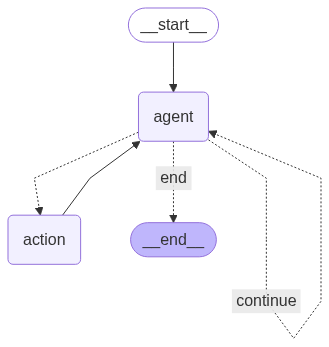

In [31]:
agent_with_helpfulness_check

- Asynchronously print updates about what our graph is doing as its nodes process the request.
  - From the output, we can see that the "agent" node requested 3 invocations of `tavily_search_results_json`, "action" returned the responses, "agent" formulated a response, and the result was deemed helpful enough to be returned without another iteration around the cycle.

In [42]:
inputs = {"messages" : [HumanMessage(content="Related to machine learning, what is LoRA? Also, who is Tim Dettmers? Also, what is Attention?")]}

async for chunk in agent_with_helpfulness_check.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values["messages"])
        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_o79Dg3TIs3wjCfXnRxFVhk4z', 'function': {'arguments': '{"query": "LoRA machine learning"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_LZBTlMjitbUriBVBIiQV3D9t', 'function': {'arguments': '{"query": "Tim Dettmers"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_tklX7rPd6NDpxHf2nTbl9YVO', 'function': {'arguments': '{"query": "Attention in machine learning"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 177, 'total_tokens': 256, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_38343a2f8f', 'id': 'c

### Task 4: LangGraph for the "Patterns" of GenAI

Let's ask our system about the 4 patterns of Generative AI:

1. Prompt Engineering
2. RAG
3. Fine-tuning
4. Agents

In [43]:
patterns = ["prompt engineering", "RAG", "fine-tuning", "LLM-based agents"]

In [44]:
for pattern in patterns:
  what_is_string = f"What is {pattern} and when did it break onto the scene??"
  inputs = {"messages" : [HumanMessage(content=what_is_string)]}
  messages = agent_with_helpfulness_check.invoke(inputs)
  print(messages["messages"][-1].content)
  print("\n\n")

Prompt engineering is the process of designing and refining input prompts to effectively communicate with AI language models, such as GPT-3 and GPT-4, to elicit desired responses. It involves crafting prompts that are clear, specific, and contextually appropriate to guide the model's output in a useful and accurate manner.

Prompt engineering has gained significant prominence with the rise of large language models (LLMs) around 2020-2021. As these models became more capable and widely accessible, users and developers recognized the importance of carefully designing prompts to maximize the utility and relevance of the generated responses. The practice has since evolved into a specialized skill, often considered a key aspect of working with AI in various applications.

Would you like more detailed information on its history, techniques, or current trends?



RAG, which stands for Retrieval-Augmented Generation, is a technique in natural language processing that combines pre-trained langu